In [1]:
%cd \BDC DATA HACKATHON\Bus_route_data\raw_GPS

D:\BDC DATA HACKATHON\Bus_route_data\raw_GPS


In [3]:
import pandas as pd
import glob
import os

# Đường dẫn đến thư mục chứa các folder tuyến xe (thay đổi cho đúng máy bạn)
root_folder = r'D:/BDC DATA HACKATHON/Bus_route_data/HCMC_bus_routes'

# List chứa các dataframe tạm
all_stops_list = []

# Dùng glob để tìm tất cả các file csv trạm trong các thư mục con
# Tìm cả chiều đi (stops_by_var) và chiều về (rev_stops_by_var)
search_patterns = [
    os.path.join(root_folder, '*', 'stops_by_var.csv'),
    os.path.join(root_folder, '*', 'rev_stops_by_var.csv')
]

print("Đang tổng hợp dữ liệu các trạm...")

for pattern in search_patterns:
    for file_path in glob.glob(pattern):
        try:
            # Đọc file
            df = pd.read_csv(file_path)

            # Chỉ lấy các cột cần thiết (để nhẹ file và dễ gộp)
            # Dựa vào ảnh bạn gửi: StopId, Code, Lat, Lng, Name (nếu có)
            cols_to_keep = ['StopId', 'Code', 'Lat', 'Lng', 'Name']

            # Lọc chỉ lấy cột tồn tại trong file để tránh lỗi
            existing_cols = [c for c in cols_to_keep if c in df.columns]
            df = df[existing_cols]

            all_stops_list.append(df)
        except Exception as e:
            print(f"Lỗi đọc file {file_path}: {e}")

# Gộp tất cả lại
if all_stops_list:
    master_stops = pd.concat(all_stops_list, ignore_index=True)

    # === QUAN TRỌNG: LOẠI BỎ TRÙNG LẶP ===
    # Giữ lại dòng đầu tiên tìm thấy của mỗi StopId
    master_stops = master_stops.drop_duplicates(subset=['StopId'])

    # Lưu ra file CSV số 1
    master_stops.to_csv('master_unique_stops.csv', index=False)
    print(f"Đã tạo xong file 'master_unique_stops.csv' với {len(master_stops)} trạm duy nhất.")
else:
    print("Không tìm thấy file nào.")

Đang tổng hợp dữ liệu các trạm...
Đã tạo xong file 'master_unique_stops.csv' với 2136 trạm duy nhất.


In [4]:
master_stops

,StopId,Code,Lat,Lng,Name
0,33,BX 06,10.776790,106.705856,Công Trường Mê Linh
1,79,Q1 031,10.773299,106.706359,Bến Bạch Đằng
2,76,Q1 020,10.770885,106.705549,Cục Hải Quan Thành Phố
3,3691,Q1 193,10.771006,106.703108,Chợ Cũ
4,2028,Q1 194,10.771043,106.701853,Trường Cao Thắng
...,...,...,...,...,...
2823,7813,Q2 112,10.789643,106.750784,Đường Đồng Văn Cống
2824,7937,TPTĐ 069,10.780259,106.752553,Đường số 52-BTT
2825,7938,TPTĐ 070,10.777947,106.753462,Ban Bồi thường GPMB Thành phố Thủ Đức
2826,7119,Q2 103,10.774613,106.756713,Trường Tiểu học Lương Thế Vinh


In [10]:
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd

# 1. Đọc dữ liệu
# File trạm chuẩn vừa tạo ở bước trên
root_folder = r'D:/BDC DATA HACKATHON/Bus_route_data/raw_GPS'
other_folder = r'D:/BDC DATA HACKATHON'
df_stops = pd.read_csv('D:/BDC DATA HACKATHON/Bus_route_data/raw_GPS/master_unique_stops.csv')
# File log GPS thô (thay tên file của bạn vào đây)
df_raw = pd.read_csv(f'{root_folder}/anonymized_raw_2025-04-01.csv')

print("Đang xử lý mapping...")

# 2. Chuẩn bị dữ liệu cho BallTree
# BallTree yêu cầu đầu vào là Radian (không phải Độ)
# Lưu ý: Ảnh bạn gửi file stops dùng 'Lat'/'Lng' (viết hoa), file raw dùng 'lat'/'lng' (thường)
stops_rad = np.radians(df_stops[['Lat', 'Lng']].values)
raw_rad = np.radians(df_raw[['lat', 'lng']].values)

# 3. Xây dựng cây tìm kiếm (BallTree) dựa trên các trạm chuẩn
# metric='haversine' để tính khoảng cách mặt cầu
tree = BallTree(stops_rad, metric='haversine')

# 4. Truy vấn tìm trạm gần nhất cho TẤT CẢ các điểm trong file Raw
# k=1 nghĩa là chỉ tìm 1 điểm gần nhất
distances, indices = tree.query(raw_rad, k=1)

# 5. Chuyển đổi khoảng cách từ Radian sang Mét
# Bán kính trái đất ~ 6371000 mét
distances_in_meters = distances * 6371000

# 6. Gán kết quả vào dataframe gốc
# Lấy StopId và tọa độ chuẩn tương ứng với index tìm được
df_raw['matched_stop_id'] = df_stops.iloc[indices.flatten()]['StopId'].values
df_raw['matched_lng'] = df_stops.iloc[indices.flatten()]['Lng'].values
df_raw['matched_lat'] = df_stops.iloc[indices.flatten()]['Lat'].values
df_raw['distance_diff_meters'] = distances_in_meters

# 7. Lọc theo ngưỡng sai số (Threshold)
# Chỉ map những điểm nào lệch dưới 20 mét (hoặc 30m tùy bạn chỉnh)
# Những điểm xa hơn coi như xe đang chạy trên đường, không phải ở trạm
THRESHOLD_METERS = 100 # Bạn có thể sửa số này

# Tạo file kết quả: Chỉ lấy những dòng khớp với trạm
matched_data = df_raw[df_raw['distance_diff_meters'] <= THRESHOLD_METERS].copy()

# Lưu file CSV thứ 2
matched_data.to_csv('mapped_gps_to_stops.csv', index=False)

print("Hoàn tất!")
print(f"Tìm thấy {len(matched_data)} điểm GPS khớp với trạm dừng (sai số <= {THRESHOLD_METERS}m).")
print("File kết quả: mapped_gps_to_stops.csv")

Đang xử lý mapping...
Hoàn tất!
Tìm thấy 1460766 điểm GPS khớp với trạm dừng (sai số <= 100m).
File kết quả: mapped_gps_to_stops.csv


In [13]:
mapped_gps_to_stops = pd.read_csv('mapped_gps_to_stops.csv')

In [14]:
mapped_gps_to_stops

,datetime,lng,lat,speed,door_up,door_down,anonymized_vehicle,anonymized_driver,matched_stop_id,matched_lng,matched_lat,distance_diff_meters
0,2025-04-01 00:00:01,106.482285,10.971292,NaN,False,False,f3a3e75584,NaN,732,106.482099,10.971617,41.484002
1,2025-04-01 00:00:28,106.512432,10.787085,NaN,False,False,6cd3c92c48,NaN,3916,106.512387,10.787026,8.175833
2,2025-04-01 00:00:01,106.820382,10.806462,NaN,False,False,4114dde0aa,NaN,1518,106.821077,10.806213,80.823318
3,2025-04-01 00:00:01,106.482203,10.971188,NaN,False,False,3ebf280097,NaN,732,106.482099,10.971617,49.007361
4,2025-04-01 00:00:21,106.701690,10.752950,NaN,False,False,cc46f5d218,NaN,2783,106.701740,10.752714,26.804431
...,...,...,...,...,...,...,...,...,...,...,...,...
1460761,2025-04-01 23:19:35,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250
1460762,2025-04-01 23:46:30,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250
1460763,2025-04-01 23:32:49,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250
1460764,2025-04-01 23:43:06,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250


In [18]:
master_stops[master_stops['Lat'] == 10.971617]

,StopId,Code,Lat,Lng,Name
1063,732,BX 63,10.971617,106.482099,Bến xe Củ Chi


In [78]:
merged_df = mapped_gps_to_stops.merge(master_stops,
                                      left_on=['matched_lng', 'matched_lat'],
                                      right_on=['Lng', 'Lat'],
                                      how='inner')
merged_df[['door_up', 'door_down']][
    (merged_df['door_up'] == True) | (merged_df['door_down'] == True)
].sum()

door_up      194026
door_down    184473
dtype: int64

In [90]:
count_door_open = merged_df.groupby('Name')[['door_up','door_down']].sum().reset_index()
count_door_open.rename(columns={'door_up':'total_door_up',
                                'door_down':'total_door_down'}, inplace=True)
count_door_open[count_door_open['total_door_up'] != 0].sort_values('total_door_up', ascending=False)

,Name,total_door_up,total_door_down
75,Bến xe buýt Sài Gòn,34729,34234
62,Bến xe Miền Tây,14604,14604
59,Bến xe An Sương,13109,13109
69,Bến xe buýt Chợ Lớn,11219,11159
65,Bến xe Ngã tư Ga,7865,7865
...,...,...,...
570,Kim Hằng,1,1
430,Cầu Ông Bé,1,1
552,Khu dân cư Galleria,1,1
513,Hồ Bơi Quận 4,1,1


In [82]:
# Group by Name, sum door_up và door_down
count_door = (
    merged_df.groupby('Name')[['door_up','door_down']]
    .sum()
    .rename(columns={'door_up':'total_door_up','door_down':'total_door_down'})
    .assign(total_door_open=lambda x: x['total_door_up'] + x['total_door_down'])
    .reset_index()
    .sort_values('total_door_open', ascending=False)
)

count_door.sort_values(by=['total_door_open'], ascending=False)

,Name,total_door_up,total_door_down,total_door_open
75,Bến xe buýt Sài Gòn,34729,34234,68963
62,Bến xe Miền Tây,14604,14604,29208
59,Bến xe An Sương,13109,13109,26218
69,Bến xe buýt Chợ Lớn,11219,11159,22378
65,Bến xe Ngã tư Ga,7865,7865,15730
...,...,...,...,...
1,"100, Vườn Lài",0,0,0
1348,Ủy Ban nhân dân Quận 12,0,0,0
1349,Ủy Ban nhân dân quận Tân Phú,0,0,0
4,"180, Vườn Lài",0,0,0


In [136]:
# Lọc các row door_up hoặc door_down = True
dup_candidates = merged_df[
    (merged_df['door_up'] == True) | (merged_df['door_down'] == True)
]

# Lấy tất cả rows duplicate theo (Lng, Lat, anonymized_vehicle)
# dups = dup_candidates[dup_candidates.duplicated(
#     subset=['Lng', 'Lat', 'anonymized_vehicle'], keep=False
# )]
#
# dup_keys = list(zip(dups['Lng'], dups['Lat'], dups['anonymized_vehicle']))

# Lọc trực tiếp
#filtered_df = merged_df[~merged_df.set_index(['Lng', 'Lat', 'anonymized_vehicle']).index.isin(dup_keys)]


# Tạo mask để xác định các hàng cần giữ lại
mask = ~(
    ((merged_df['door_up'] == True) | (merged_df['door_down'] == True)) &
    merged_df.duplicated(subset=['Lng', 'Lat', 'anonymized_vehicle'], keep=False)
)

filtered_df = merged_df[mask]

In [99]:
#dup_keys

[(106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),
 (106.634019, 10.808689, '28ccc303d4'),


In [112]:
# Giải thích: GPS bắt không chính xác nên sẽ có sai số, ví dụ tại trạm Đài Liệt Sỹ xe buýt đậu từ 0:00 đến 4:30 sáng sau đó di chuyển
merged_df[
    (merged_df['Lng'] == 106.634019) &
    (merged_df['Lat'] == 10.808689) &
    (merged_df['anonymized_vehicle'] == '28ccc303d4')
].sort_values(by=['datetime'], ascending=True)

,datetime,lng,lat,speed,door_up,door_down,anonymized_vehicle,anonymized_driver,matched_stop_id,matched_lng,matched_lat,distance_diff_meters,StopId,Code,Lat,Lng,Name
4292,2025-04-01 00:00:32,106.633385,10.809201,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,89.645699,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
4294,2025-04-01 00:02:02,106.633354,10.809194,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,91.808048,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
4391,2025-04-01 00:03:32,106.633347,10.809189,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,92.077332,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
4301,2025-04-01 00:05:03,106.633347,10.809191,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,92.211784,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
4372,2025-04-01 00:06:33,106.633354,10.809193,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,91.740079,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460023,2025-04-01 23:59:16,106.633369,10.809175,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,89.222204,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
1460146,2025-04-01 23:59:26,106.633369,10.809175,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,89.222204,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
1460170,2025-04-01 23:59:36,106.633369,10.809175,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,89.222204,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ
1460129,2025-04-01 23:59:46,106.633369,10.809175,NaN,True,True,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,89.222204,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ


In [113]:
merged_df[
    (merged_df['Lng'] == 106.689362) &
    (merged_df['Lat'] == 10.767676) &
    (merged_df['anonymized_vehicle'] == 'a0fff796e3')
].sort_values(by=['datetime'], ascending=True)

,datetime,lng,lat,speed,door_up,door_down,anonymized_vehicle,anonymized_driver,matched_stop_id,matched_lng,matched_lat,distance_diff_meters,StopId,Code,Lat,Lng,Name
4421,2025-04-01 00:00:07,106.688995,10.767740,NaN,True,True,a0fff796e3,14d68a57b47395de1b4e4833c01bf73d,35,106.689362,10.767676,40.716743,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
4413,2025-04-01 00:00:17,106.688995,10.767740,NaN,True,True,a0fff796e3,14d68a57b47395de1b4e4833c01bf73d,35,106.689362,10.767676,40.716743,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
4445,2025-04-01 00:00:27,106.688995,10.767740,NaN,True,True,a0fff796e3,14d68a57b47395de1b4e4833c01bf73d,35,106.689362,10.767676,40.716743,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
4424,2025-04-01 00:00:37,106.688995,10.767740,NaN,True,True,a0fff796e3,14d68a57b47395de1b4e4833c01bf73d,35,106.689362,10.767676,40.716743,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
4481,2025-04-01 00:00:47,106.688995,10.767740,NaN,True,True,a0fff796e3,14d68a57b47395de1b4e4833c01bf73d,35,106.689362,10.767676,40.716743,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126670,2025-04-01 16:59:07,106.689781,10.767378,7.0,False,False,a0fff796e3,2fef9f0b1dfa459988ef45207a4af934,35,106.689362,10.767676,56.505988,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
1127659,2025-04-01 16:59:17,106.689865,10.767301,4.0,False,False,a0fff796e3,2fef9f0b1dfa459988ef45207a4af934,35,106.689362,10.767676,68.977000,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
1127322,2025-04-01 16:59:27,106.689873,10.767289,NaN,True,True,a0fff796e3,2fef9f0b1dfa459988ef45207a4af934,35,106.689362,10.767676,70.481802,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn
1127716,2025-04-01 16:59:37,106.689873,10.767282,3.0,False,False,a0fff796e3,2fef9f0b1dfa459988ef45207a4af934,35,106.689362,10.767676,70.959708,35,BX 01,10.767676,106.689362,Bến xe buýt Sài Gòn


In [149]:
filtered_df[
    (filtered_df['Lng'] == 106.634019) &
    (filtered_df['Lat'] == 10.808689) &
    (filtered_df['anonymized_vehicle'] == '28ccc303d4')
].sort_values(by=['datetime'], ascending=True)

,datetime,lng,lat,speed,door_up,door_down,anonymized_vehicle,anonymized_driver,matched_stop_id,matched_lng,matched_lat,distance_diff_meters,StopId,Code,Lat,Lng,Name,StopType
61022,2025-04-01 04:13:28,106.633377,10.809324,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,99.511280,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
61114,2025-04-01 04:13:38,106.633377,10.809324,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,99.511280,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
61158,2025-04-01 04:13:48,106.633377,10.809324,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,99.511280,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
60966,2025-04-01 04:13:58,106.633377,10.809324,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,99.511280,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
60952,2025-04-01 04:14:08,106.633377,10.809323,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,99.432412,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405899,2025-04-01 20:48:03,106.633347,10.809116,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,87.415851,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
1405884,2025-04-01 20:48:13,106.633347,10.809121,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,87.719072,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
1406142,2025-04-01 20:48:23,106.633347,10.809123,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,87.841053,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ
1406468,2025-04-01 20:48:33,106.633347,10.809128,NaN,False,False,28ccc303d4,2fef9f0b1dfa459988ef45207a4af934,177,106.634019,10.808689,88.147721,177,QTP 014,10.808689,106.634019,Trạm Đài Liệt Sỹ,Nhà chờ


In [156]:
count_door = (
    filtered_df.groupby('Name')[['door_up','door_down']]
    .sum()
    .rename(columns={'door_up':'total_door_up','door_down':'total_door_down'})
    .assign(total_door_open=lambda x: x['total_door_up'] + x['total_door_down'])
    .reset_index()
    .sort_values('total_door_open', ascending=False)
)

count_door.sort_values(by=['total_door_open'], ascending=False)

,Name,total_door_up,total_door_down,total_door_open
1327,Đại học Nông Lâm,0,0,0
1337,Đạt Hòa,0,0,0
1338,Đầm Sen,0,0,0
1339,Đầu cầu xéo,0,0,0
10,"84-86, Đại Lộ 2",0,0,0
...,...,...,...,...
742,Ngã tư Bình Triệu,1,0,1
767,Nhà sách Minh Khai,1,0,1
788,Nhà hàng Đông Phương,1,0,1
966,Trường CĐKT Cao Thắng,1,1,2


In [116]:
master_stops = pd.read_csv('master_unique_stops.csv')

In [187]:
count_door_open.sort_values(by='total_door_up', ascending=False)

,Name,total_door_up,total_door_down
75,Bến xe buýt Sài Gòn,34729,34234
62,Bến xe Miền Tây,14604,14604
59,Bến xe An Sương,13109,13109
69,Bến xe buýt Chợ Lớn,11219,11159
65,Bến xe Ngã tư Ga,7865,7865
...,...,...,...
728,Ngã ba Phạm Huy Thông,0,0
778,Nhà Tưởng niệm Liệt sỹ Nhà Bè,0,0
842,Phú thọ Hòa,0,0
782,Nhà bia tưởng niệm,0,0


In [199]:
# FULL HD
merged_df = mapped_gps_to_stops.merge(master_stops,
                                      left_on=['matched_lng', 'matched_lat'],
                                      right_on=['Lng', 'Lat'],
                                      how='inner')
merged_df[['door_up', 'door_down']][
    (merged_df['door_up'] == True) | (merged_df['door_down'] == True)].sum()

# Trước khi lọc bán kính
count_door_open = merged_df.groupby('Name')[['door_up', 'door_down']].sum().reset_index()
count_door_open.rename(columns={'door_up': 'total_door_up',
                                'door_down': 'total_door_down'}, inplace=True)
count_door_open[count_door_open['total_door_up'] != 0].sort_values('total_door_up', ascending=False)


# Group by Name, sum door_up và door_down
count_door = (
    merged_df.groupby('Name')[['door_up','door_down']]
    .sum()
    .rename(columns={'door_up':'total_door_up','door_down':'total_door_down'})
    .assign(total_door_open=lambda x: x['total_door_up'] + x['total_door_down'])
    .reset_index()
    .sort_values('total_door_open', ascending=False)
)

count_door.sort_values(by=['total_door_open'], ascending=False)

# Sau khi lọc
# Giải thích: GPS bắt không chính xác nên sẽ có sai số, ví dụ tại trạm Đài Liệt Sỹ xe buýt đậu từ 0:00 đến 4:30 sáng sau đó di chuyển
dup_candidates = merged_df[
    (merged_df['door_up'] == True) | (merged_df['door_down'] == True)
]

,Name,total_door_up,total_door_down,total_door_open
40,Bình Hưng,1,1,2
966,Trường CĐKT Cao Thắng,1,1,2
408,Cầu Sài Gòn,1,0,1
110,Bệnh viện Trưng Vương,1,0,1
276,Cá sấu Hoa Cà,1,0,1
...,...,...,...,...
1336,Đại lộ 2,0,0,0
1337,Đạt Hòa,0,0,0
1338,Đầm Sen,0,0,0
1339,Đầu cầu xéo,0,0,0


In [200]:
dup_candidates = merged_df[
    (merged_df['door_up'] == True) | (merged_df['door_down'] == True)
]

# Lấy tất cả rows duplicate theo (Lng, Lat, anonymized_vehicle)
dups = dup_candidates[dup_candidates.duplicated(
    subset=['Lng', 'Lat', 'anonymized_vehicle'], keep=False
)]
dup_tuples = list(zip(dups['Lng'], dups['Lat'], dups['anonymized_vehicle']))

filtered_df = merged_df[
    ~merged_df.set_index(['Lng','Lat','anonymized_vehicle']).index.isin(dup_tuples)
]

count_door = (
    filtered_df.groupby('Name')[['door_up','door_down']]
    .sum()
    .rename(columns={'door_up':'total_door_up','door_down':'total_door_down'})
    .assign(total_door_open=lambda x: x['total_door_up'] + x['total_door_down'])
    .reset_index()
    .sort_values('total_door_open', ascending=False)
)

count_door.sort_values(by=['total_door_open'], ascending=False)

,Name,total_door_up,total_door_down,total_door_open
1068,Trạm Trung chuyển trên đường Hàm Nghi,59,54,113
59,Bến xe An Sương,33,33,66
62,Bến xe Miền Tây,32,32,64
495,Hưng Nhơn,30,30,60
245,Chợ Thủ Đức,29,29,58
...,...,...,...,...
44,Bông Sen,0,0,0
49,Bưu điện An Nhơn,0,0,0
1299,Đường số 13,0,0,0
53,Bảo tàng Tôn Đức Thắng,0,0,0


In [176]:
dup_candidates = merged_df[
    (merged_df['door_up'] == True) | (merged_df['door_down'] == True)
]

# Tạo mask để xác định các hàng cần giữ lại
mask = ~(
    ((merged_df['door_up'] == True) | (merged_df['door_down'] == True)) &
    merged_df.duplicated(subset=['Lng', 'Lat', 'anonymized_vehicle'], keep=False)
)

filtered_df = merged_df[mask]

# count_door = (
#     filtered_df.groupby('Name')[['door_up','door_down']]
#     .sum()
#     .rename(columns={'door_up':'total_door_up','door_down':'total_door_down'})
#     .assign(total_door_open=lambda x: x['total_door_up'] + x['total_door_down'])
#     .reset_index()
#     .sort_values('total_door_open', ascending=False)
# )

count_door = filtered_df.groupby('Name')[['door_up', 'door_down']].sum().reset_index()
count_door.rename(columns={'door_up': 'total_door_up',
                           'door_down': 'total_door_down'}, inplace=True)

# Thêm cột tổng lượt mở cửa
count_door['total_door_open'] = count_door['total_door_up'] + count_door['total_door_down']

count_door

,Name,total_door_up,total_door_down,total_door_open
0,Ngã ba Hòa Hưng,0,0,0
1,"100, Vườn Lài",0,0,0
2,"14-16, Vườn Lài",0,0,0
3,"176, Lê Văn Thịnh",0,0,0
4,"180, Vườn Lài",0,0,0
...,...,...,...,...
1352,Ủy ban nhân dân Bình Hưng Hòa B,0,0,0
1353,Ủy ban phường Tân Thuận Tây,0,0,0
1354,Ủy ban thị trấn Tân Túc,0,0,0
1355,Ủy ban xã Hưng Long,0,0,0


In [180]:
merged_df

,datetime,lng,lat,speed,door_up,door_down,anonymized_vehicle,anonymized_driver,matched_stop_id,matched_lng,matched_lat,distance_diff_meters,StopId,Code,Lat,Lng,Name,StopType
0,2025-04-01 00:00:01,106.482285,10.971292,NaN,False,False,f3a3e75584,NaN,732,106.482099,10.971617,41.484002,732,BX 63,10.971617,106.482099,Bến xe Củ Chi,Bến xe
1,2025-04-01 00:00:28,106.512432,10.787085,NaN,False,False,6cd3c92c48,NaN,3916,106.512387,10.787026,8.175833,3916,HBC 327,10.787026,106.512387,Cầu Rau Răm,Trụ dừng
2,2025-04-01 00:00:01,106.820382,10.806462,NaN,False,False,4114dde0aa,NaN,1518,106.821077,10.806213,80.823318,1518,Q9 161,10.806213,106.821077,Chợ Long Trường,Trụ dừng
3,2025-04-01 00:00:01,106.482203,10.971188,NaN,False,False,3ebf280097,NaN,732,106.482099,10.971617,49.007361,732,BX 63,10.971617,106.482099,Bến xe Củ Chi,Bến xe
4,2025-04-01 00:00:21,106.701690,10.752950,NaN,False,False,cc46f5d218,NaN,2783,106.701740,10.752714,26.804431,2783,BX 12,10.752714,106.701740,Bến xe buýt Kho Muối,Bến xe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460761,2025-04-01 23:19:35,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250,1122,HNB 064,10.626002,106.737370,Thành Công,Trụ dừng
1460762,2025-04-01 23:46:30,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250,1122,HNB 064,10.626002,106.737370,Thành Công,Trụ dừng
1460763,2025-04-01 23:32:49,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250,1122,HNB 064,10.626002,106.737370,Thành Công,Trụ dừng
1460764,2025-04-01 23:43:06,106.737358,10.625748,NaN,False,False,541cbe2c1a,NaN,1122,106.737370,10.626002,28.235250,1122,HNB 064,10.626002,106.737370,Thành Công,Trụ dừng


In [178]:
count_door_open = filtered_df.groupby('Name')[['door_up', 'door_down']].sum().reset_index()
count_door_open.rename(columns={'door_up': 'total_door_up',
                                'door_down': 'total_door_down'}, inplace=True)
count_door_open[count_door_open['total_door_up'] != 0].sort_values('total_door_up', ascending=False)

,Name,total_door_up,total_door_down
40,Bình Hưng,1,1
51,Bảo Tàng Miền Đông,1,0
105,Bệnh viện Quận Tân Bình,1,0
110,Bệnh viện Trưng Vương,1,0
276,Cá sấu Hoa Cà,1,0
408,Cầu Sài Gòn,1,0
432,Cầu Ông Lãnh,1,0
448,Cổng trước SVĐ Quân Khu 7,1,0
645,Nguyễn Kim,1,0
742,Ngã tư Bình Triệu,1,0


In [ ]:
count_door.sort_values(by=['total_door_open'], ascending=False)

In [ ]:
count_door.to_csv('count_door_open.csv', index=False)

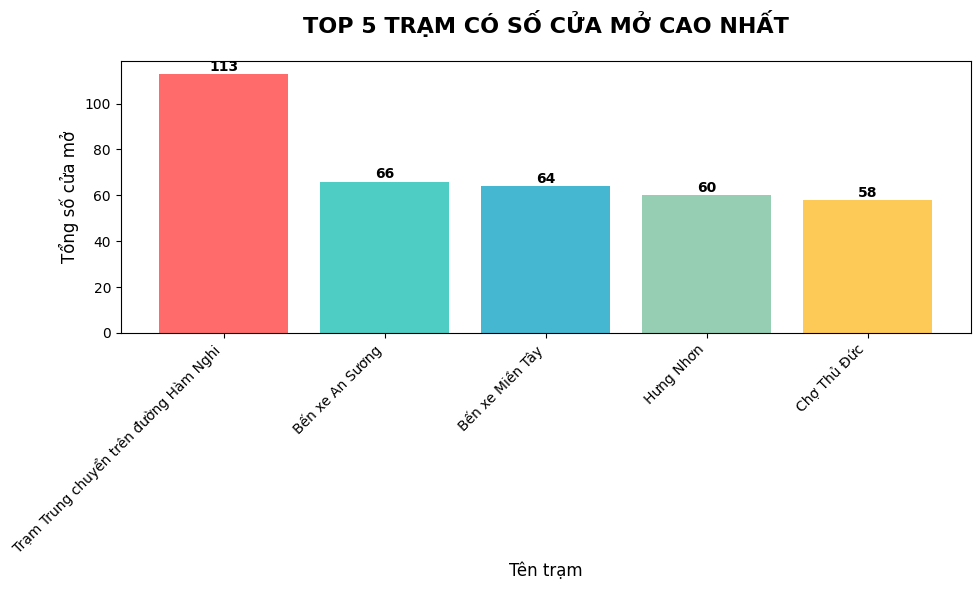

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy top 5
top_5 = count_door.nlargest(5, 'total_door_open')

plt.figure(figsize=(10, 6))
bars = plt.bar(top_5['Name'], top_5['total_door_open'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
plt.title('TOP 5 TRẠM CÓ SỐ CỬA MỞ NHIỀU NHẤT TRONG NGÀY', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tên trạm', fontsize=12)
plt.ylabel('Tổng số cửa mở', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Thêm số liệu trên mỗi cột
for bar, value in zip(bars, top_5['total_door_open']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
processed_GPS